# uploading data

In [3]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import xmltodict
from numcodecs import Blosc
import numpy as np
import zarr as zarr
import tifffile as tf
from PIL import Image as im
import cv2 
from skimage.io import imread
from skimage.exposure import cumulative_distribution #calculate the cumulative pixel value
import imagecodecs
from skimage import exposure
from skimage.exposure import match_histograms
import pandas as pd
import os
import json
import codecs
import pickle

In [4]:
tiff_store_polaris=tf.imread('/uftp/src/palettes/Calib_Polaris_Scan3.qptiff', aszarr=True)
zarr_store_polaris = zarr.open(tiff_store_polaris, mode='r')

In [10]:
tiff_store_huron10 = tf.imread("/uftp/src/palettes/Calib_R1_10_10_10_202402.tif", aszarr=True)
zarr_store_huron10 = zarr.open(tiff_store_huron10, mode='r')

<tifffile.TiffPage 6 @11318147692> missing data offset tag


In [3]:
tiff_store_huron = tf.imread("/uftp/src/palettes/IHCjul23_020723_2.ome.tiff", aszarr=True)
zarr_store_huronIHC = zarr.open(tiff_store_huron, mode='r')

In [4]:
tiff_store_huron = tf.imread("/uftp/src/palettes/HEjul23_020723.ome.tiff", aszarr=True)
zarr_store_huronHEjul = zarr.open(tiff_store_huron, mode='r')

In [5]:
tiff_store_huron = tf.imread("/uftp/src/palettes/Calib_R1_22_22_22_202402.tif", aszarr=True)
zarr_store_huron22 = zarr.open(tiff_store_huron, mode='r')

<tifffile.TiffPage 6 @11318147692> missing data offset tag


In [6]:
tiff_store_huron = tf.imread("/uftp/src/palettes/Calib_R1_11_12_19_202402.tif", aszarr=True)
zarr_store_huron3g = zarr.open(tiff_store_huron, mode='r')

<tifffile.TiffPage 6 @11318147692> missing data offset tag


### 1000 micron

From each image I crop a small pallette of 1000 micron and flip/rotate it if neccessary to obtain a series of images with A1 circle at bottom right corner 

In [5]:
#polaris crop, g=1.8
scale_factor_polaris=round(2.00011**2)
biggest_polaris=zarr_store_polaris[4]
polaris_crop=biggest_polaris[1119*scale_factor_polaris:1417*scale_factor_polaris, 120*scale_factor_polaris:300*scale_factor_polaris, :]

In [11]:
#Calib_R1_10_10_10 crop, linear image
scale_factor_zarr=4
biggest_huron=zarr_store_huron10[2]
huron_crop=biggest_huron[(865*scale_factor_zarr) : (1175*scale_factor_zarr), (420*scale_factor_zarr) : (595*scale_factor_zarr), :]
huron_crop = np.flip(huron_crop, axis=1)
#plt.imshow(huron_crop)

In [8]:
#IHCjul23 crop, g=1.05, 1.1, 1.9
biggest_huron=zarr_store_huronIHC[2]
huronIHC_crop=biggest_huron[(1060*scale_factor_zarr) : (1370*scale_factor_zarr), (433*scale_factor_zarr) : (608*scale_factor_zarr), :]
huronIHC_crop = np.flip(huronIHC_crop, axis=1)
#plt.imshow(huronIHC_crop)

In [9]:
#HEjul23 crop, g=1.5, 1.3, 1.1
biggest_huron=zarr_store_huronHEjul[2]
huronHEjul_crop=biggest_huron[(1057*scale_factor_zarr) : (1366*scale_factor_zarr), (433*scale_factor_zarr) : (608*scale_factor_zarr), :]
huronHEjul_crop = np.flip(huronHEjul_crop, axis=1)
#plt.imshow(huronHEjul_crop)

In [10]:
#Calib_R1_22_22_22 crop, g=2.2
biggest_huron=zarr_store_huron22[2]
huron22_crop=biggest_huron[(865*scale_factor_zarr) : (1175*scale_factor_zarr), (420*scale_factor_zarr) : (595*scale_factor_zarr), :]
huron22_crop = np.flip(huron22_crop, axis=1)
#plt.imshow(huron22_crop)

In [11]:
#Calib_R1_11_12_19, g=1.1, 1.2, 1.9 - same for HEsep23
biggest_huron=zarr_store_huron3g[2]
huron3g_crop=biggest_huron[(868*scale_factor_zarr) : (1178*scale_factor_zarr), (420*scale_factor_zarr) : (595*scale_factor_zarr), :]
huron3g_crop = np.flip(huron3g_crop, axis=1)
#plt.imshow(huron3g_crop)

# gammas

In [5]:
#transfer function
def transfer_function(img, values, mode='linearization'):
  '''
  This function takes the image and performs transformation based on two modes: default 'linearization' outputs image with 1.0 gamma,
  any other input for 'mode' (e.g. 'correction') applies gamma(s) to an image. Single float/int number or list of numbers can be inputed
  as 'values' parameter (see dictionary below). 
  Gamma values: {'polaris_NTSC': 1.8, 'huron_sRGB_22_22_22': 2.2, 'huron_sRGB_IHCjul23': [1.05, 1.1, 1.9], 'huron_sRGB_11_12_19': [1.1, 1.2, 1.9],
  'huron_sRGB_HEjul23': [1.5, 1.3, 1.1]}
  '''

  img_norm=img/255.0 #converts array values from 0-255 range to 0-1
  if isinstance(values, (float, int)): #this part is needed to handle both single numbers and a list of gammas
    values = [values]
  if len(values)!=1:
    transposed=np.transpose(img_norm, (2,0,1)) #dimension with color channels becomes the first in order
    modified=np.empty_like(transposed)
    for i, gamma in enumerate(values):
      modified[i]=transposed[i]**(gamma if mode == 'linearization' else 1/gamma)
    modified=np.transpose(modified, (1,2,0))
  else:
    gamma = values[0]
    modified=img_norm**(gamma if mode == 'linearization' else 1/gamma)

  modified=(modified*255).astype(np.uint8)
  plt.imshow(modified)
  return modified

# histogram matching using CDF

In [6]:
#mathing function based on skimage
def _match_cumulative_cdf(source, ref):

    ''' 
    Function counts cumulative sum of pixel intensity for each channel
    '''
    source_lut = source.reshape(-1) #converts channel to 1d numpy array
    source_counts = np.bincount(source_lut) #counts frequency of each unique pixel value - i.e. the resulting amount of bins isn't 256, 
    #but depends on the number of unique pixels
    ref_counts = np.bincount(ref.reshape(-1)) #same as the previous one

    # omit values where the count was 0
    ref_values = np.nonzero(ref_counts)[0] #outputs the indexes of pixels with non-zero cumsum intensity
    ref_counts = ref_counts[ref_values] #leaves only pixels with nonzero cumsum as bin counts of reference image
    
    # normalizing values for each array - I checked both ways of normalizing by diving on counts.max() and by image.size() - results are the same, so
    # I decided to use the same function as in skimage
    source_quantiles = np.cumsum(source_counts) / source.size
    ref_quantiles = np.cumsum(ref_counts) / ref.size

    interp_a_values = np.interp(source_quantiles, ref_quantiles, ref_values) #applying LUT
    
    return interp_a_values[source_lut].reshape(source.shape)

def match_images(source, reference):
    ''' 
    Just splits images to channels
    '''

    matched = np.empty(source.shape, dtype=source.dtype)
    for channel in range(source.shape[-1]):
        matched_channel = _match_cumulative_cdf(
            source[..., channel], reference[..., channel]
            )
        matched[..., channel] = matched_channel
    
    return matched
    

# Applying gamma correction and histogram matching on pallettes

## Linearization

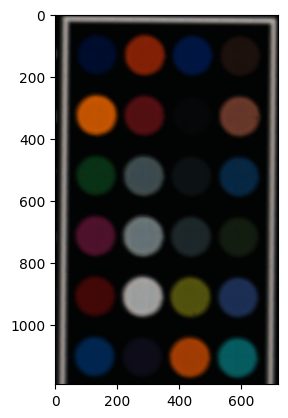

In [19]:
polaris_linear=transfer_function(polaris_crop, 1.8)

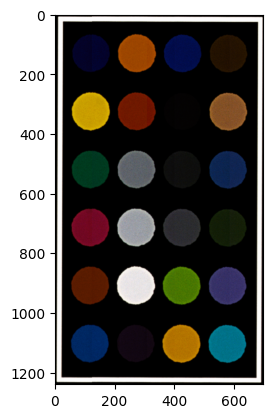

In [20]:
IHC_lin=transfer_function(huronIHC_crop, [1.05, 1.1, 1.9])

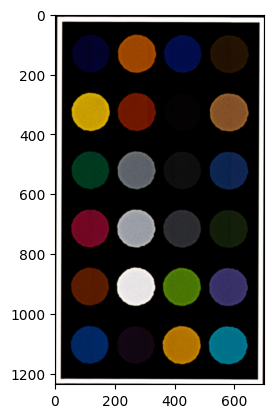

In [21]:
HEjul_lin=transfer_function(huronHEjul_crop, [1.5, 1.3, 1.1])

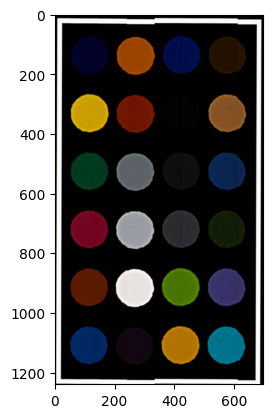

In [22]:
huron22_lin=transfer_function(huron22_crop, 2.2)

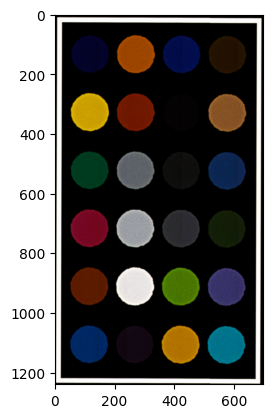

In [23]:
huron3g_lin=transfer_function(huron3g_crop, [1.1, 1.2, 1.9])

## Polaris reference 

In [24]:
h10_v_pol=match_images(huron_crop, polaris_linear)

In [25]:
IHC_v_pol=match_images(IHC_lin, polaris_linear)

In [26]:
HEjul_v_pol=match_images(HEjul_lin, polaris_linear)

In [27]:
huron22_v_pol=match_images(huron22_lin, polaris_linear)

In [28]:
huron3g_v_pol=match_images(huron3g_lin, polaris_linear)

## Huron reference

In [29]:
pol_v_h10=match_images(polaris_linear, huron_crop)

In [30]:
pol_v_IHC=match_images(polaris_linear, IHC_lin)

In [31]:
pol_v_HEjul=match_images(polaris_linear, HEjul_lin)

In [32]:
pol_v_h22=match_images(polaris_linear, huron22_lin)

In [33]:
pol_v_h3g=match_images(polaris_linear, huron3g_lin)

## CTF

polaris reference

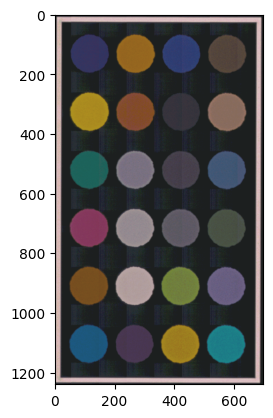

In [34]:
h10_v_pol_corr=transfer_function(h10_v_pol, 1.8, 'correction')

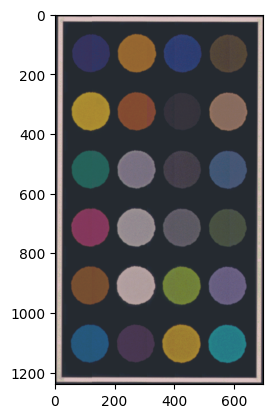

In [35]:
IHC_v_pol_corr=transfer_function(IHC_v_pol, 1.8, 'correction')

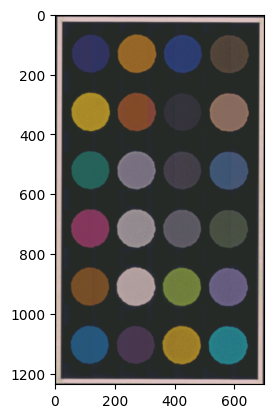

In [36]:
HEjul_v_pol_corr=transfer_function(HEjul_v_pol, 1.8, 'correction')

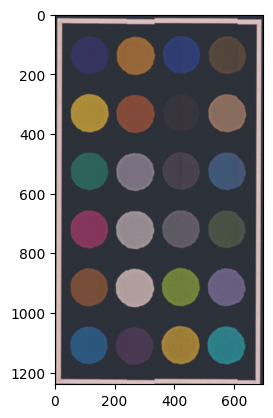

In [37]:
huron22_v_pol_corr=transfer_function(huron22_v_pol, 1.8, 'correction')

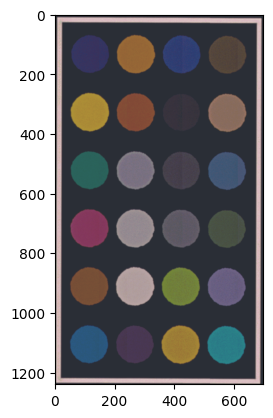

In [38]:
huron3g_v_pol_corr=transfer_function(huron3g_v_pol, 1.8, 'correction')

(-0.5, 699.5, 1239.5, -0.5)

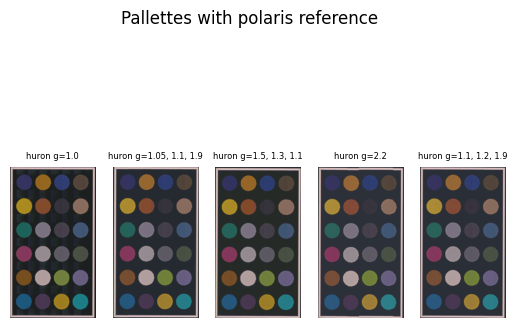

In [39]:
fig, axs = plt.subplots(ncols=5)
fig.suptitle('Pallettes with polaris reference')
axs[0].imshow(h10_v_pol_corr)
axs[0].set_title('huron g=1.0', fontsize=6)
axs[0].axis('off')
axs[1].imshow(IHC_v_pol_corr)
axs[1].set_title('huron g=1.05, 1.1, 1.9', fontsize=6)
axs[1].axis('off')
axs[2].imshow(HEjul_v_pol_corr)
axs[2].set_title('huron g=1.5, 1.3, 1.1', fontsize=6)
axs[2].axis('off')
axs[3].imshow(huron22_v_pol_corr)
axs[3].set_title('huron g=2.2', fontsize=6)
axs[3].axis('off')
axs[4].imshow(huron3g_v_pol_corr)
axs[4].set_title('huron g=1.1, 1.2, 1.9', fontsize=6)
axs[4].axis('off')

huron reference

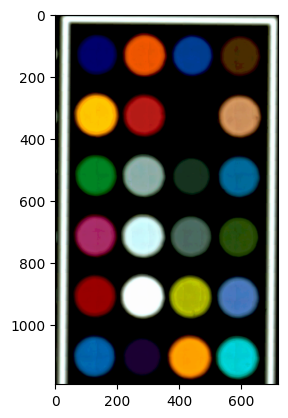

In [41]:
pol_v_h10_corr=transfer_function(pol_v_h10, 2.0, 'correction')

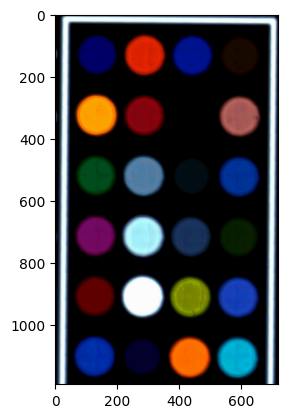

In [42]:
pol_v_IHC_corr=transfer_function(pol_v_IHC, [1.05, 1.1, 1.9], 'correction')

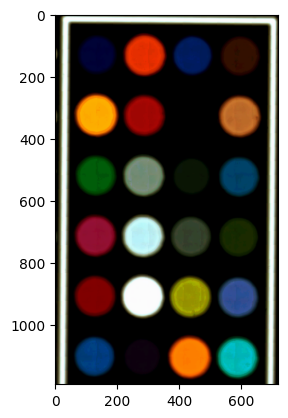

In [43]:
pol_v_HEjul_corr=transfer_function(pol_v_HEjul, [1.5, 1.3, 1.1], 'correction')

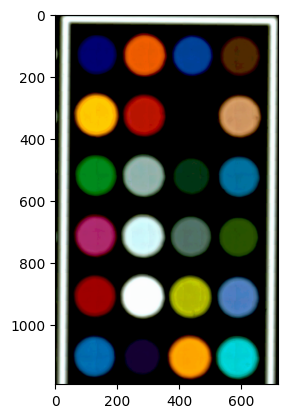

In [44]:
pol_v_h22_corr=transfer_function(pol_v_h22, 2.2, 'correction')

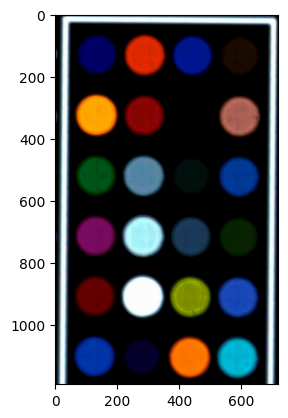

In [45]:
pol_v_h3g_corr=transfer_function(pol_v_h3g, [1.1, 1.2, 1.9], 'correction')

(-0.5, 719.5, 1191.5, -0.5)

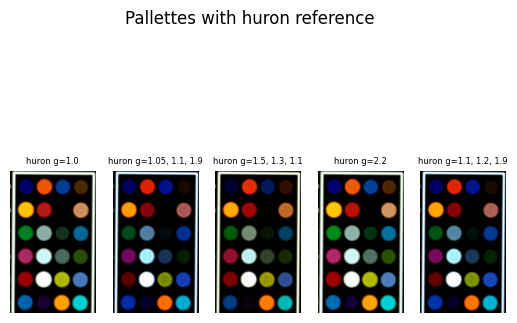

In [46]:
fig, axs = plt.subplots(ncols=5)
fig.suptitle('Pallettes with huron reference')
axs[0].imshow(pol_v_h10_corr)
axs[0].set_title('huron g=1.0', fontsize=6)
axs[0].axis('off')
axs[1].imshow(pol_v_IHC_corr)
axs[1].set_title('huron g=1.05, 1.1, 1.9', fontsize=6)
axs[1].axis('off')
axs[2].imshow(pol_v_HEjul_corr)
axs[2].set_title('huron g=1.5, 1.3, 1.1', fontsize=6)
axs[2].axis('off')
axs[3].imshow(pol_v_h22_corr)
axs[3].set_title('huron g=2.2', fontsize=6)
axs[3].axis('off')
axs[4].imshow(pol_v_h3g_corr)
axs[4].set_title('huron g=1.1, 1.2, 1.9', fontsize=6)
axs[4].axis('off')

# Parameters savings

Creating txt files of a dictionary with the parameters needed as a reference for matching images. I'm using a 'pickle' package that simplifies the process of writing and reading dictionaries with numpy arrays. 

In [12]:
def ref_dict(image, file_name:str, directory:str):
    '''
    Function for creating a file with necessary parameters for image matching. Output file can be used for applying histogram correction to a 
    source image without a reference one (see 'match_images' function above). That way we can calibrate any image using only calculated parameters. 
    
    Three variables ​​are supplied to the input: 
    'image' - reference image to which we will calibrate a source image, 
    'file_name' - the name of output file, 
    'directory' - path to a directory to which output file will be saved.
    '''
    image_dict={'counts': {0: None, 1: None, 2: None},
           'values': {0: None, 1: None, 2: None}, 'quantiles': {0: None, 1: None, 2: None}} #dictionary with parameters as keys; each one stores 
    #calculated values for each channel 
    
    rgbs=[]
    for i in range(3):
        rgbs.append(image[..., i]) #splitting image into three channels 
    
    for channel in range(3): #calculating parameters from match_images function
        ref_counts=np.bincount(rgbs[channel].reshape(-1))
        image_dict['values'][channel]=np.nonzero(ref_counts)[0].tolist()
        image_dict['counts'][channel]=ref_counts[image_dict['values'][channel]].tolist()
        image_dict['quantiles'][channel] = (np.cumsum(image_dict['counts'][channel]) / image.size).tolist()

    file_path = os.path.join(directory, f"{file_name}.txt") 

    with open(file_path, "wb") as file:
        pickle.dump(image_dict, file) #writing a file that stores created dictionary; it's a txt file written in binary format, so it can't be previwed 

    return image_dict

Histograms for all pallettes stored in 'reference_files' directory on server alongside with json file that contains paths to all these files. 

In [15]:
# ref_dict(polaris_crop, 'polaris_ref', '/uftp/src/reference_files')
# ref_dict(huron_crop, 'h_10_10_10_ref', '/uftp/src/reference_files')
# ref_dict(huronIHC_crop, 'h_IHC_ref', '/uftp/src/reference_files')
# ref_dict(huronHEjul_crop, 'h_HEjul_ref', '/uftp/src/reference_files')
# ref_dict(huron22_crop, 'h_22_22_22_ref', '/uftp/src/reference_files')
# ref_dict(huron3g_crop, 'h_11_12_19_ref', '/uftp/src/reference_files')

{'counts': {0: [285426,
   211542,
   9254,
   6937,
   6716,
   7279,
   9140,
   10509,
   7913,
   3486,
   1966,
   1628,
   1684,
   1728,
   1831,
   2034,
   2387,
   2943,
   3422,
   3816,
   4201,
   4626,
   4888,
   4802,
   4582,
   4014,
   3138,
   2386,
   1753,
   1318,
   986,
   706,
   538,
   505,
   492,
   545,
   630,
   721,
   870,
   1049,
   1195,
   1225,
   1417,
   1533,
   1469,
   1494,
   1412,
   1298,
   1370,
   1331,
   1322,
   1370,
   1359,
   1346,
   1359,
   1267,
   1259,
   1191,
   1123,
   1128,
   1153,
   1130,
   1133,
   1090,
   1154,
   1060,
   1096,
   977,
   921,
   871,
   850,
   854,
   760,
   758,
   756,
   699,
   757,
   751,
   713,
   824,
   797,
   777,
   800,
   832,
   780,
   701,
   811,
   742,
   684,
   679,
   688,
   675,
   700,
   787,
   903,
   1031,
   1245,
   1397,
   1637,
   1766,
   1819,
   1863,
   1835,
   1770,
   1504,
   1453,
   1286,
   1074,
   986,
   850,
   780,
   742,
   728,
   746,

In [34]:
#de-serializing pickle files from binary to python dictionary 

# with open('/uftp/src/reference_files/polaris_ref.txt', 'rb') as handle:
#     dict = pickle.load(handle)

## json saving 

In [8]:
json_w_paths={'polaris': '/uftp/src/reference_files/polaris_ref.txt', 'huron10_10_10': '/uftp/src/reference_files/h_10_10_10_ref.txt',
              'huronIHC': '/uftp/src/reference_files/h_IHC_ref.txt', 'huronHEjul': '/uftp/src/reference_files/h_HEjul_ref.txt', 
              'huron22': '/uftp/src/reference_files/h_22_22_22_ref.txt', 'huron3g': '/uftp/src/reference_files/h_11_12_19_ref.txt'}

In [9]:
with open('/uftp/src/reference_files/path_to_files.json', 'w') as json_file:
    json.dump(json_w_paths, json_file, indent=2)

In [40]:
with open('path_to_files.json', 'r') as json_file:
    json_dict=json.load(json_file)

## testing matching without reference 

In [ ]:
def _calc_cumulative_cdf(source, ref):

    ''' 
    Function counts cumulative sum of pixel intensity for each channel
    '''
    source_lut = source.reshape(-1) #converts channel to 1d numpy array
    source_counts = np.bincount(source_lut) #counts frequency of each unique pixel value - i.e. the resulting amount of bins isn't 256, 
    #but depends on the number of unique pixels
    ref_counts = np.bincount(ref.reshape(-1)) #same as the previous one

    # omit values where the count was 0
    ref_values = np.nonzero(ref_counts)[0] #outputs the indexes of pixels with non-zero cumsum intensity
    ref_counts = ref_counts[ref_values] #leaves only pixels with nonzero cumsum as bin counts of reference image
    
    # normalizing values for each array - I checked both ways of normalizing by diving on counts.max() and by image.size() - results are the same, so
    # I decided to use the same function as in skimage
    source_quantiles = np.cumsum(source_counts) / source.size
    ref_quantiles = np.cumsum(ref_counts) / ref.size

    interp_a_values = np.interp(source_quantiles, ref_quantiles, ref_values) #applying LUT
    
    return interp_a_values[source_lut].reshape(source.shape)

def test_matching(source, ref_dict):
    ''' 
    Just splits images to channels
    '''

    matched = np.empty(source.shape, dtype=source.dtype)
    for channel in range(source.shape[-1]):
        matched_channel = _match_cumulative_cdf(
            source[..., channel], reference[..., channel]
            )
        matched[..., channel] = matched_channel
    
    return matched

In [13]:
polaris_ref=ref_dict(polaris_crop, 'test', '/home/erutkovskaya/colour_project')